# 1) Ajustement des paramètres pour le virus de la vaccine via le modèle continu

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# Chargement des données virus
 
dfV = pd.read_csv('Virus.csv', header=None)
dataV = dfV[1].values
timeV = dfV[0].values


def V_interp(t):
    t = np.asarray(t)
    return np.interp(t, timeV, dataV, left=dataV[0], right=0)
df = pd.read_csv('UTF-8DataVacciniaVirus_0.csv')
time = df["Time (Days)"].values
N_avg, N_std = df["Naive (avg)"].values, df["Naive (std)"].values
A_avg, A_std = df["Effector (avg)"].values, df["Effector (std)"].values
M_avg, M_std = df["Memory (avg)"].values, df["Memory (std)"].values

# Code 1: on Compare la somme simulée N + A + M avec le total mesuré fourni dans le fichier total.CSV.

In [4]:
def mod_cont(Y, t, params):
    N, A, M = Y
    a = 1
    sigma_M = 1e-5
    al, p, r, K = params  # paramètres : alpha, rho, r, K
    Vt = V_interp(t)
    denom = K + Vt
    # Pour éviter une division par zéro, on définit ft = 0 si denom == 0
    ft = Vt / denom if np.all(denom) != 0 else 0
    
    dN = -a * ft * N
    dA = a * ft * (N + M) + p * ft * A - (1 - ft) * (r + al) * A
    dM = (1 - ft) * r * A - a * ft * M - sigma_M * M
    return np.array([dN, dA, dM])


In [5]:
def midpoint_method(f, y0, params, h, T):
  
    t_val = np.arange(0, T + h, h)
    Y = np.zeros((len(t_val), len(y0)))
    Y[0] = y0
    for i in range(len(t_val) - 1):
        k1 = f(Y[i], t_val[i], params)
        Y_mid = Y[i] + (h/2) * k1
        k2 = f(Y_mid, t_val[i] + h/2, params)
        Y[i + 1] = Y[i] + h * k2
    return t_val, Y

In [6]:
def simulate_continu(params):
    # Conditions initiales
    N0, A0, M0 = 100, 0, 0
    Y0 = [N0, A0, M0]
    h = 0.1
    T = 28
    t_val, sol = midpoint_method(mod_cont, Y0, params, h, T)
    N = np.clip(sol[:, 0], 0, None)
    A = np.clip(sol[:, 1], 0, None)
    M = np.clip(sol[:, 2], 0, None)
    return N, A, M, t_val

 

In [7]:
def erreur_continu(params, time, data):
    N, A, M, t_val = simulate_continu(params)
    sim = N + A + M
    # Interpolation de la solution simulée aux temps de mesure
    interp_fun = interp1d(t_val, sim, kind='linear', fill_value="extrapolate")
    sim_interp = interp_fun(time)
    sim_interp = np.maximum(sim_interp, 1e-8)
    data = np.maximum(data, 1e-8)
    return np.log1p(data) - np.log1p(sim_interp)


In [8]:
def fit_and_plot_lm( csv_path, initial_params):
    try:
        df = pd.read_csv(csv_path, header=None)
    except FileNotFoundError:
        print(f"Fichier {csv_path} introuvable. Fin de la fonction.")
        return None, None
    
    time = df[0].values
    data = df[1].values
    
    # Ajustement par moindres carrés
    result = least_squares(erreur_continu, initial_params, args=(time, data), method='lm', verbose=2)
    best_params = result.x

    # Simulation et prédiction du total
    N_sim, A_sim, M_sim, t_val = simulate_continu(best_params)
    pred_total = N_sim + A_sim + M_sim

    # Interpolation de la solution simulée aux temps de mesure
    interp_fun = interp1d(t_val, pred_total, kind='linear', fill_value="extrapolate")
    pred_interp = interp_fun(time)

    safe_pred = np.maximum(pred_interp, 1e-8)
    data_safe = np.maximum(data, 1e-8)
    ssr = np.sum((np.log1p(data_safe) - np.log1p(safe_pred))**2)
    
    
    print("Meilleurs paramètres :", best_params)
    print("SSR =", ssr)
    
    # Affichage
    plt.figure(figsize=(8, 5))
    plt.plot(time, data, 'o', label='Données')
    plt.plot(t_val, pred_total, '-', label='Modèle')
    plt.plot(t_val, V_interp(t_val), label='V (Charge virale)', color='red', linestyle='--')
 
    #plt.title(f'{epitope_name} Fit (LM)')
    plt.xlabel("Temps (jours)")
    plt.ylabel("Celulles T CD8+  ")
    plt.legend()
    plt.yscale('log', base=10)
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    plt.ylim(1e0, 1e10)
    plt.xlim(0, 50)
    plt.grid(True)
    plt.savefig("continu_vacc_code_1.png", dpi=300, bbox_inches='tight')
    plt.show()

        # Affichage
    plt.figure(figsize=(8, 5))
    #plt.plot(time, data, 'o', label='Données')
    #plt.plot(time, A_avg, 'o', label='Données A')
    #plt.plot(time,M_avg, 'o', label='Données M')
    plt.plot(t_val, V_interp(t_val), label='V (Charge virale)', color='red', linestyle='--')
    plt.plot(t_val,A_sim,'-',label='A simulé')
    plt.plot(t_val,M_sim,'-',label='M simulé')
    #plt.title(f'{epitope_name} Fit (LM)')
    plt.xlabel("Temps (jours)")
    plt.ylabel("Celulles T CD8+  ")
    plt.legend()
    plt.yscale('log', base=10)
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    plt.ylim(1e0, 1e8)
    plt.xlim(0, 30)
    plt.grid(True)
    plt.show()
    
    return best_params, ssr


<ipython-input-4-a701c9345183>:13: RuntimeWarning: overflow encountered in double_scalars
  dM = (1 - ft) * r * A - a * ft * M - sigma_M * M
<ipython-input-4-a701c9345183>:12: RuntimeWarning: invalid value encountered in double_scalars
  dA = a * ft * (N + M) + p * ft * A - (1 - ft) * (r + al) * A
<ipython-input-4-a701c9345183>:12: RuntimeWarning: overflow encountered in double_scalars
  dA = a * ft * (N + M) + p * ft * A - (1 - ft) * (r + al) * A
<ipython-input-4-a701c9345183>:13: RuntimeWarning: invalid value encountered in double_scalars
  dM = (1 - ft) * r * A - a * ft * M - sigma_M * M


`ftol` termination condition is satisfied.
Function evaluations 135, initial cost 1.6346e+01, final cost 1.3159e+01, first-order optimality 2.22e-04.
Meilleurs paramètres : [2.41296914e-01 9.07987155e-01 2.52060752e-01 5.54266835e+02]
SSR = 26.318433351529553


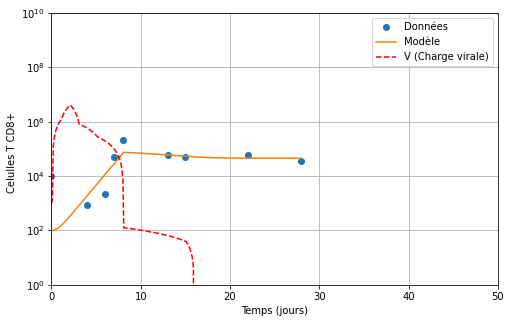

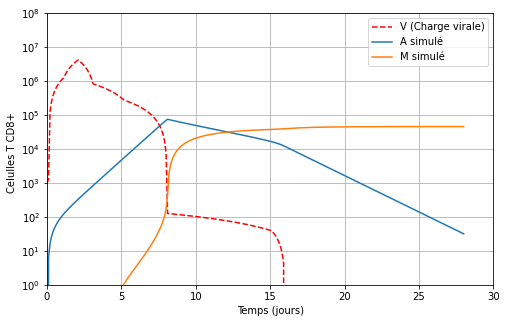

Paramètres optimisés: [2.41296914e-01 9.07987155e-01 2.52060752e-01 5.54266835e+02]
SSR: 26.318433351529553


In [9]:
#initial_params=[0.5, 0.2, 0.1, 100]
initial_params = [0.01, 1, 1, 1000] # 1
#initial_params=[0.1,0.1,0.1,100]
#initial_params=[0.1,0.1,0.1,100]
#initial_params=[0.0001,0.001,0.001,1000]
#initial_params =initial_params =[0.01,0.1,0.1,10]

best_params, ssr_val = fit_and_plot_lm( 'total.csv', initial_params)
print("Paramètres optimisés:", best_params)
print("SSR:", ssr_val)

# 2) corrélation entre entre N0 et les paramètres ajustés #

Matrice de corrélation :
              N0     alpha       rho         r         K
N0     1.000000 -0.856713 -0.908545 -0.884736  0.985901
alpha -0.856713  1.000000  0.993539  0.998263 -0.763382
rho   -0.908545  0.993539  1.000000  0.997859 -0.828744
r     -0.884736  0.998263  0.997859  1.000000 -0.799665
K      0.985901 -0.763382 -0.828744 -0.799665  1.000000


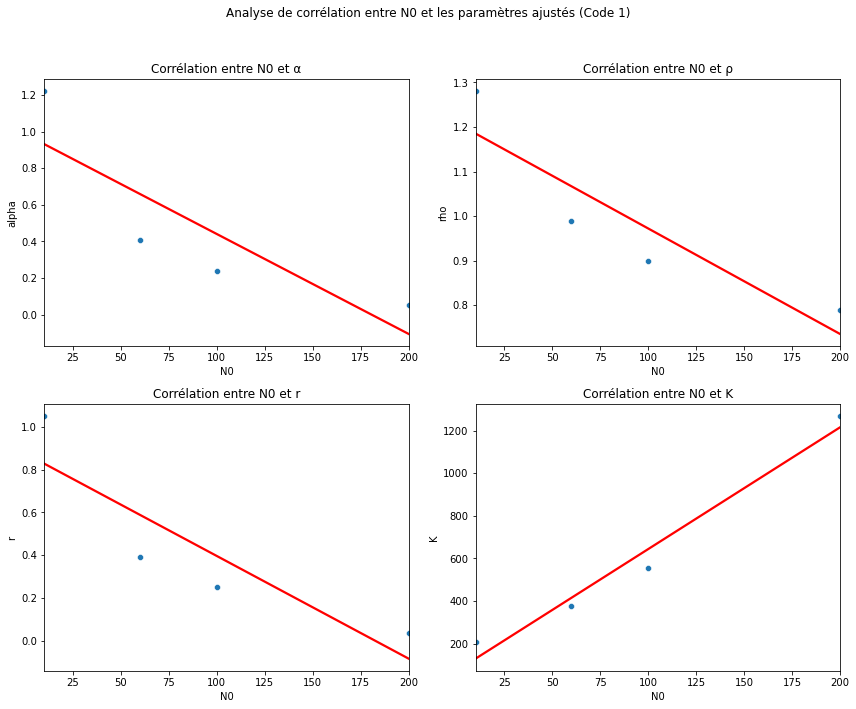

In [10]:
#données ajustées

data = {
    'N0': [10, 60, 100, 200],
    'alpha': [1.22, 0.41, 0.24, 0.054],
    'rho': [1.28, 0.99, 0.90, 0.79],
    'r': [1.05, 0.39, 0.25, 0.037],
    'K': [206, 375, 554, 1268],
}

df = pd.DataFrame(data)

# matrice de corrélation 
corr_matrix = df.corr()
print("Matrice de corrélation :\n", corr_matrix)

#  Graphiques des corrélations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# alpha vs N0
sns.scatterplot(x='N0', y='alpha', data=df, ax=axs[0,0])
sns.regplot(x='N0', y='alpha', data=df, ax=axs[0,0], scatter=False, color='red', ci=None)
axs[0,0].set_title("Corrélation entre N0 et α")

# rho vs N0
sns.scatterplot(x='N0', y='rho', data=df, ax=axs[0,1])
sns.regplot(x='N0', y='rho', data=df, ax=axs[0,1], scatter=False, color='red', ci=None)
axs[0,1].set_title("Corrélation entre N0 et ρ")

# r vs N0
sns.scatterplot(x='N0', y='r', data=df, ax=axs[1,0])
sns.regplot(x='N0', y='r', data=df, ax=axs[1,0], scatter=False, color='red', ci=None)
axs[1,0].set_title("Corrélation entre N0 et r")

# K vs N0
sns.scatterplot(x='N0', y='K', data=df, ax=axs[1,1])
sns.regplot(x='N0', y='K', data=df, ax=axs[1,1], scatter=False, color='red', ci=None)
axs[1,1].set_title("Corrélation entre N0 et K")

plt.suptitle("Analyse de corrélation entre N0 et les paramètres ajustés (Code 1)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
